In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from time_series_utils import WindowGen   

In [2]:
cols= ['time','missing_info','job_id','task_index','machineid','event_type','user','sch_class',
       'priority','cpu_req','mem_req','disk_req','machine_restr']

n_files = 200
try:
    df = pd.read_csv(f'data_{n_files}.zip',index_col=0)
except:
    print('Loading new data...')
    data= pd.DataFrame()
    for i in range(n_files):
        try:
            df = pd.read_csv('data/'+sorted(os.listdir('data'))[i],names=cols)
            df[['job_id','task_index']] = df[['job_id','task_index']].astype(str)
            df['n_tasks'] = df['job_id']+df['task_index']
            df['slot']=df['time']//120000000
            df = df[['slot','n_tasks','cpu_req','mem_req']].drop_duplicates('n_tasks')
            df = df.groupby('slot',as_index=True).agg({"n_tasks": 'count',"cpu_req": np.sum,'mem_req': np.sum})
            data = pd.concat([data,df],axis=0)
        except:
            continue
    df = data.reset_index(drop=True)
    df.to_csv(f'data_{n_files}.zip')
    print('Data is loaded.')


In [3]:
df

,n_tasks,cpu_req,mem_req
0,346,13.939781,12.503087
1,442,15.958219,13.809937
2,1183,30.124597,29.633960
3,106,6.233949,3.070520
4,920,10.904767,11.287415
...,...,...,...
8488,406,9.528836,4.151624
8489,2483,69.594540,34.237972
8490,2270,70.014075,18.984662
8491,971,11.598564,6.873451


<AxesSubplot:ylabel='mem_req'>

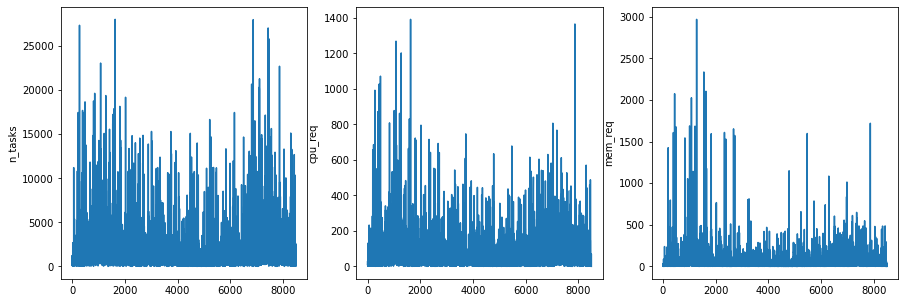

In [4]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
sns.lineplot(ax= axes[0], x=df.index,y=df['n_tasks'])
sns.lineplot(ax= axes[1], x=df.index,y=df['cpu_req'])
sns.lineplot(ax= axes[2], x=df.index,y=df['mem_req'])

In [5]:
# Data Transformations
df['n_tasks'] = np.log(df['n_tasks'])

In [6]:
def norm(output,input= input):
    mean = input.mean()
    std = input.std()
    return (output-mean)/std

In [10]:
# Split data into train and test sets
n_samples = df.shape[0]
split = 0.1

train_df = df[:round(n_samples*(1-split))]
test_df = df[round(n_samples*(1-split)):]

In [12]:
train_df.shape

(7644, 3)

In [13]:
train_df = train_df.apply(norm, axis=1, input=train_df)
test_df = test_df.apply(norm, axis=1, input=train_df)

In [14]:
# Reshape data according to a given window
step = 60
window = WindowGen(step)

X_train, y_train = window(train_df,column_names=['n_tasks'],label_names=['n_tasks'])
X_test, y_test = window(test_df,column_names=['n_tasks'],label_names=['n_tasks'])

In [10]:
y_train.shape

TensorShape([7584, 1, 1])

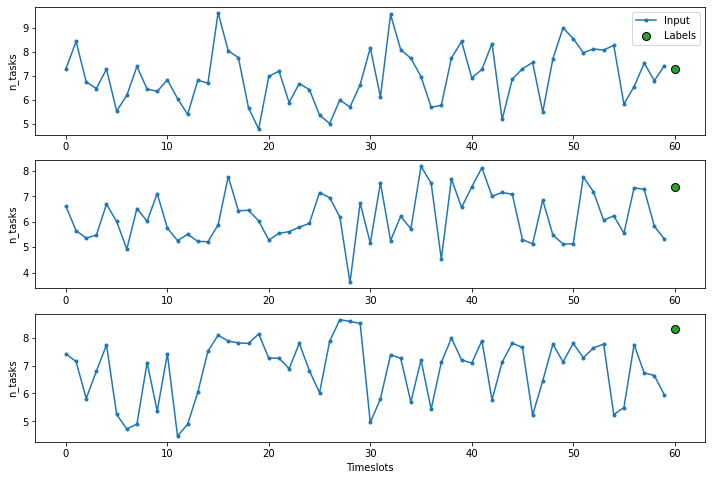

In [11]:
window.plot(plt_col='n_tasks')

In [12]:
import tensorflow as tf
import keras_tuner as kt
from tuner import HpModel

C:\Users\anton\AppData\Local\Programs\anaconda3\envs\tf2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [13]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './tmp/checkpoint',
    save_weights_only=True,
    monitor='loss',
    save_best_only=True)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,
#     patience=30)

loss = tf.keras.losses.MeanSquaredError()
EPOCHS = 1000

In [17]:
def model_builder(hp):
    input = tf.keras.Input(shape=(step,1))
    LSTM1 = hp.Int('units1', min_value=50, max_value=60, step=2)
    # LSTM2 = hp.Int('units2', min_value=20, max_value=55, step=1)
    lstm1 = tf.keras.layers.LSTM(units=LSTM1,return_sequences=True)(input)
    lstm2 = tf.keras.layers.LSTM(units=LSTM1)(lstm1)
    logits = tf.keras.layers.Dense(1)(lstm2)
    
    return tf.keras.Model(inputs=input, outputs=logits)

In [18]:
model = HpModel(model=model_builder,loss=loss,epochs=EPOCHS)

tuner = kt.RandomSearch(objective=kt.Objective("val_loss", "min"), max_trials=1, hypermodel=model,
    directory="results", project_name="custom_training", overwrite=True,)

In [19]:
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test))

Trial 1 Complete [00h 05m 55s]
val_loss: 18.474971771240234

Best val_loss So Far: 18.474971771240234
Total elapsed time: 00h 05m 55s
INFO:tensorflow:Oracle triggered exit


In [26]:
best_hps = tuner.get_best_hyperparameters(5)

In [18]:
tf.config.run_functions_eagerly(True)

In [26]:
for i in best_hps:
    print(i.values)

{'units1': 54, 'units2': 21, 'batch_size': 3000, 'learning_rate': 0.004619604548269685}
{'units1': 52, 'units2': 24, 'batch_size': 2000, 'learning_rate': 0.0021291840426046296}
{'units1': 52, 'units2': 24, 'batch_size': 2000, 'learning_rate': 0.001}
{'units1': 53, 'units2': 24, 'batch_size': 3000, 'learning_rate': 0.0005832353636090387}
{'units1': 52, 'units2': 23, 'batch_size': 1000, 'learning_rate': 0.00016468966822474475}


In [22]:
def model_builder():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(step,1)))
    model.add(tf.keras.layers.LSTM(units=54,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=54))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.004619604548),
                  loss = tf.keras.losses.MeanSquaredError())
    
    return model
model = model_builder()

In [23]:
model.fit(x=X_train,y=y_train, validation_data=(X_test,y_test),epochs=1500,batch_size=3000,
          callbacks=[model_checkpoint_callback])

Epoch 1/1500
3/3 [==============================] - 4s 398ms/step - loss: 0.9344 - val_loss: 27.8432
Epoch 2/1500
3/3 [==============================] - 0s 131ms/step - loss: 0.8644 - val_loss: 25.8213
Epoch 3/1500
3/3 [==============================] - 0s 136ms/step - loss: 0.8550 - val_loss: 22.6558
Epoch 4/1500
3/3 [==============================] - 0s 135ms/step - loss: 0.8418 - val_loss: 24.2191
Epoch 5/1500
3/3 [==============================] - 0s 137ms/step - loss: 0.8348 - val_loss: 27.3917
Epoch 6/1500
3/3 [==============================] - 0s 135ms/step - loss: 0.8264 - val_loss: 31.1404
Epoch 7/1500
3/3 [==============================] - 0s 126ms/step - loss: 0.8238 - val_loss: 31.4657
Epoch 8/1500
3/3 [==============================] - 0s 119ms/step - loss: 0.8221 - val_loss: 29.9401
Epoch 9/1500
3/3 [==============================] - 0s 133ms/step - loss: 0.8206 - val_loss: 28.7265
Epoch 10/1500
3/3 [==============================] - 0s 124ms/step - loss: 0.8195 - val_los

KeyboardInterrupt: 

In [32]:
model.load_weights('./tmp/checkpoint')

In [33]:
fin = model.predict(X_train)

In [34]:
m = tf.keras.metrics.MeanSquaredError()
m.update_state(fin,y_train)
print('Root mean squared loss is: ', m.result().numpy())

Root mean squared loss is:  0.0014312554


In [22]:
# y_train=y_train.reshape(-1)
# y_test=y_test.reshape(-1)
# fin= fin.reshape(-1)
y= [1,2]
x = [1,3]
m = tfa.metrics.r_square.RSquare()
m.update_state(x, y)
print('R-squared is: ', m.result().numpy())

R-squared is:  0.5


In [36]:
fin

array([[-0.87499315],
       [ 1.004493  ],
       [ 0.557678  ],
       ...,
       [-1.1706197 ],
       [-1.1159264 ],
       [-1.214663  ]], dtype=float32)

In [37]:
y_train

<tf.Tensor: shape=(7584, 1, 1), dtype=float64, numpy=
array([[[-0.87796194]],

       [[ 0.98357014]],

       [[ 0.55097215]],

       ...,

       [[-1.13136509]],

       [[-1.1546944 ]],

       [[-1.14046995]]])>

In [ ]:
y_train_e=np.exp(y_train)
fin_e=np.exp(fin)

In [ ]:
y_pred = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['Prediction' for i in range(len(fin))],'mem_req':fin_e})
y_true = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['True' for i in range(len(fin))],'mem_req':y_train_e})
final = pd.concat([y_pred,y_true], axis=0)

In [ ]:
sns.lineplot(x='slot',y= 'mem_req', ci=None, 
             hue='Class', data=final.reset_index())